<img style="float: right;" src="../bvlecture_exercises/htwlogo.jpg">

# Linear regression with pytorch

**Author**: Dive into Deep Learning, adapted by _Erik Rodner_<br>
**Lecture**: Computer Vision and Machine Learning I

In the following exercise, we implement a simple linear regression method using pytorch - and all the definitions and optimizers that are common for deep learning - enjoy.

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l
import matplotlib.pylab as plt

import sys
import os
sys.path.append(os.path.join("..", "bvlecture_exercises", "utils"))

from vectorgen import synthetic_data

### Generating synthetic data

In the following, we generate and visualize some synthetic data in two dimensions that we use to define the regression task. 
Since this is simulated data, we exactly know the linear model parameters and can compare them with the ones
the optimizer yields.

In [2]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print (f"Shape of X (features): {features.shape}")
print (f"Shape of y (labels): {labels.shape}")

Shape of X (features): torch.Size([1000, 2])
Shape of y (labels): torch.Size([1000, 1])


Above code does not deal with numpy arrays as in previous notebooks. Instead, we use arrays defined in the (py)torch framework. They have the benefit of automatically being allocated on a GPU (if configured) and automatically stored in computational graph. 

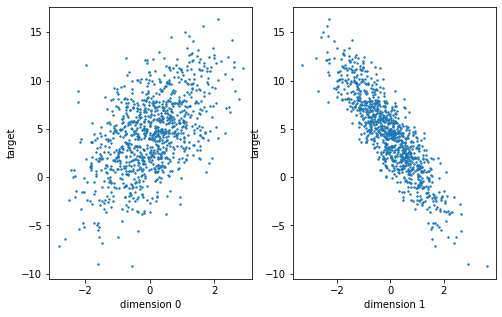

In [4]:
plt.figure(figsize=(8,5))
for i_dim in range(2):
    plt.subplot(1,2,i_dim+1)
    plt.scatter(features[:, i_dim].numpy(),
                labels.numpy(), 2)
    plt.ylabel("target")
    plt.xlabel(f"dimension {i_dim}")
plt.show()

### Defining the data iterator for later SGD

Stochastic gradient descent requires taking out multiple examples from the training set as a batch. This is implemented
in a data iterator. The data iterator decomposes the training set into batches of ``batch_size`` random examples. 

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    
    # The examples are read at random, in no particular order,
    # therefore, let us shuffle some indices
    indices = list(range(num_examples))
    random.shuffle(indices)
    
    # now we can output multiple random batches, ensuring
    # that a single examples is only present in one batch during a single epoch
    for i in range(0, num_examples, batch_size):
        # the min command ensures that we do not get into trouble at the end of 
        # the epoch
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

If we apply the data iterator in a for loop and outputs batches for whole dataset. Looping once over the whole training set is 
referred to as ``epoch``.

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break # we have enough :)

tensor([[-0.4256,  1.1281],
        [ 0.5646,  0.1495],
        [ 0.0860,  0.5038],
        [-0.6273,  0.4839],
        [-0.1703, -1.0593],
        [ 0.5011,  0.9125],
        [-0.0882, -0.2992],
        [ 0.0131,  0.4722],
        [ 1.4712,  0.3001],
        [-0.5557, -2.0311]]) 
 tensor([[-0.4913],
        [ 4.8034],
        [ 2.6477],
        [ 1.2862],
        [ 7.4679],
        [ 2.1278],
        [ 5.0272],
        [ 2.6169],
        [ 6.1185],
        [ 9.9870]])


### Defining the model and its parameters

Ok, data iterator/loader is ready. Now it is time to define the following:
1. Initial values of the parameters $w$ and $b$
2. The linear model ``linreg``: $\hat{y}(X; w,b) = X*w + b$ - note that this definition allows multiple examples as input - $X$ is a matrix
3. The loss function ``squared_loss``: $\|\hat{y}-y\|^2$
4. How the SGD optimization should work: ``sgd``

In [7]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
def linreg(X, w, b):  
    """The linear regression model."""
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y): 
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [10]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        # loop through all parameters and
        # perform a single update step and zero the gradients afterwards
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### Optimization

Let us start the optimization by running SGD for some epochs.

In [11]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # forward pass
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # backward pass
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        # Update parameters using their gradient
        sgd([w, b], lr, batch_size)  
        
    # simply output some loss function statistics by performing
    # a forward pass again WITHOUT backward pass
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.026321
epoch 2, loss 0.000092
epoch 3, loss 0.000051
epoch 4, loss 0.000051
epoch 5, loss 0.000051
epoch 6, loss 0.000051
epoch 7, loss 0.000051
epoch 8, loss 0.000051
epoch 9, loss 0.000051
epoch 10, loss 0.000051


### Compare estimated model parameters with the ground-truth

In [12]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([6.9857e-05, 2.7442e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([-8.3447e-05], grad_fn=<RsubBackward1>)
